# TFM Tutorial Notebook 1: Foundations of Tabular/Timeseries Data

In this tutorial, we are going to run a few traditional ML models on one tabular and one timeseries data through AutoGluon. In order to do so, you need to install AutoGluon either on the cloud or locally. Please use the following instructions

``!python -m pip install -upgrade pip``

``!python -m pip install autogluon``

**Note: Most of the contents in the following follows tutorials from AutoGluon.**

## 1. Tabular Data

The tabular dataset is from the cover story of [Nature issue 7887: AI-guided intuition for math theorems](https://www.nature.com/articles/s41586-021-04086-x.pdf). The goal is to predict a knot's signature based on its properties. We sampled 10K training and 5K test examples from the [original data](https://github.com/google-deepmind/mathematics_conjectures/blob/main/knot_theory.ipynb). The sampled dataset make this tutorial run quickly, but AutoGluon can handle the full dataset if desired.

We load this dataset directly from a URL. AutoGluon's ``TabularDataset`` is a subclass of pandas DataFrame, so any ``DataFrame`` methods can be used on ``TabularDataset`` as well.

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor

data_url = 'https://raw.githubusercontent.com/mli/ag-docs/main/knot_theory/'
train_data = TabularDataset(f'{data_url}train.csv')
train_data.head()

C:\Users\zhjiang\AppData\Local\miniconda3\envs\tabfm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Unnamed: 0,chern_simons,cusp_volume,hyperbolic_adjoint_torsion_degree,hyperbolic_torsion_degree,injectivity_radius,longitudinal_translation,meridinal_translation_imag,meridinal_translation_real,short_geodesic_imag_part,short_geodesic_real_part,Symmetry_0,Symmetry_D3,Symmetry_D4,Symmetry_D6,Symmetry_D8,Symmetry_Z/2 + Z/2,volume,signature
0,70746,0.090530,12.226322,0,10,0.507756,10.685555,1.144192,-0.519157,-2.760601,1.015512,0.0,0.0,0.0,0.0,0.0,1.0,11.393225,-2
1,240827,0.232453,13.800773,0,14,0.413645,10.453156,1.320249,-0.158522,-3.013258,0.827289,0.0,0.0,0.0,0.0,0.0,1.0,12.742782,0
2,155659,-0.144099,14.761030,0,14,0.436928,13.405199,1.101142,0.768894,2.233106,0.873856,0.0,0.0,0.0,0.0,0.0,0.0,15.236505,2
3,239963,-0.171668,13.738019,0,22,0.249481,27.819496,0.493827,-1.188718,-2.042771,0.498961,0.0,0.0,0.0,0.0,0.0,0.0,17.279890,-8
4,90504,0.235188,15.896359,0,10,0.389329,15.330971,1.036879,0.722828,-3.056138,0.778658,0.0,0.0,0.0,0.0,0.0,0.0,16.749298,4


The target or label column is the **signature** one, which has 18 unique integers. Even though pandas didn't correctly recognize this data type sa categorical, AutoGluon can fix this issue automatically.

In [2]:
label = 'signature'
train_data[label].describe()

count    10000.000000
mean        -0.022000
std          3.025166
min        -12.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max         12.000000
Name: signature, dtype: float64

## Training

We can now construct a ``TabularPredictor`` by specifying the label column name and then train on the dataset with TabularPredictor.fit(). We don't need to specify any other parameters, which is similar to using Scikit-Learn. AutoGluon can also recognize this is a multi-class classification task and perform automatic feature engineering, training multiple models and ensembling the models to create the final predictor.

In [3]:
# You can also specify the time_limit to limit the total training time.
# Higher time limits will generally result in better prediction performance,
# and excessively low time limits will prevent AutoGluon from training and
# ensembling a reasonable set of models.

predictor = TabularPredictor(label=label).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels\ag-20251024_152730"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:       1.58 GB / 15.93 GB (9.9%)
Disk Space Avail:   232.93 GB / 476.33 GB (48.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize accur

## Prediction

Once we have a predictor that is fit on the training dataset, we can load a separate set of data to use for prediction and evaulation.

In [4]:
test_data = TabularDataset(f'{data_url}test.csv')

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

Loaded data from: https://raw.githubusercontent.com/mli/ag-docs/main/knot_theory/test.csv | Columns = 19 / 19 | Rows = 5000 -> 5000


0   -4
1   -2
2    0
3    4
4    2
Name: signature, dtype: int64

## Evaluation

We can evaluate the predictor on the test dataset using the ``evaluate()`` function, which measures how well our predictor performs on data that was not used for fitting the models.

In [5]:
predictor.evaluate(test_data, silent=True)

{'accuracy': 0.9484,
 'balanced_accuracy': np.float64(0.7561540836468318),
 'mcc': np.float64(0.936759058123347)}

## Individual Model's Performance

AutoGluon's ``TabularPredictor`` also provides the ``leaderboard()`` function, which allows us to evaluate the performance of each individual trained model on the test data.

In [6]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.9484,0.962963,accuracy,0.424562,0.058669,25.182123,0.011968,0.004365,0.126578,2,True,12
1,LightGBM,0.9456,0.955956,accuracy,0.154870,0.018302,3.979631,0.154870,0.018302,3.979631,1,True,3
2,XGBoost,0.9448,0.956957,accuracy,0.340214,0.032164,7.897377,0.340214,0.032164,7.897377,1,True,9
3,LightGBMLarge,0.9444,0.949950,accuracy,0.394578,0.040316,8.468166,0.394578,0.040316,8.468166,1,True,11
4,CatBoost,0.9432,0.955956,accuracy,0.046871,0.018761,40.221091,0.046871,0.018761,40.221091,1,True,6
5,RandomForestEntr,0.9384,0.949950,accuracy,0.195372,0.069082,2.048010,0.195372,0.069082,2.048010,1,True,5
6,ExtraTreesGini,0.9360,0.946947,accuracy,0.300236,0.068666,1.020438,0.300236,0.068666,1.020438,1,True,7
7,ExtraTreesEntr,0.9358,0.942943,accuracy,0.301444,0.066055,0.970662,0.301444,0.066055,0.970662,1,True,8
8,RandomForestGini,0.9352,0.944945,accuracy,0.243676,0.067747,2.058304,0.243676,0.067747,2.058304,1,True,4
9,LightGBMXT,0.9320,0.945946,accuracy,0.201352,0.030133,5.429735,0.201352,0.030133,5.429735,1,True,2


## 2. Time-series Data

This tutorial demonstrates how to quickly start using AutoGluon to generate hourly forecasts for the [M4 forecasting competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) dataset.

Compared to regular tabular dataset, which typically has no time correlation between any two samples, the time correlation in time-series data makes the analysis more challenging and difficult. However, time-series data can be converted into a tabular format such that tabular foundation models can be used correspondingly.

## Loading time-series data as a ``TimeSeriesDataFrame``

``TimeSeriesDataFrame`` makes it easy to store a dataset consisting of multiple time series.

In [7]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [8]:
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


AutoGluon expects time series data in **long** format. Each row of the dataframe contains a single observation (timestamp) of a single time series represented by

1. Unique ID of the time series ("item_id") as ``int`` or ``str``
2. Timestamp of the observation ("timestamp") as a pandas.Timestamp or compatible format
3. Numeric value of the time series ("target")

The raw data should always follow this format with at least three columns for unique ID, timestamp, and target value, but the name these columns can be arbitrary. It is important, however that we provide the names of the columns when constructing ``TimeSeriesDataFrame`` that is used by AutoGluon. AutoGluon will raise an exception if the data doesn't match the expected format.

In [9]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

## Training Time-series Models with ``TimeSeriesPredictor.fit``

The time series is measured at hourly frequency, so we set ``prediction_length=48`` to train models that forecast up to 48 hours into the future.

When doing time series analysis, the sampling frequency matters! Generally speaking, the higher sampling frequency, the more variance your data will have. That way, the prediction horizon should be determined carefully. Also, since there are no standard to tell under what threshold value, the learned model is a good model, we try to get the minimal error metrics.

In [10]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'C:\Users\zhjiang\Documents\tabfm_tutorial\autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       2.36 GB / 15.93 GB (14.8%)
Disk Space Avail:   232.49 GB / 476.33 GB (48.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 148060 rows, 200 

## Generating forecasts with ``TimeSeriesPredictor.predict``

By default, AutoGluon will make forecasts using the model that had the best score on the internal validation set. The forecast always includes predictions for the next ``prediction_length`` timestamps, starting from the end of each time series in ``train_data``

In [11]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  622.258958  597.920728  606.426970  612.850452   
        1750-01-30 05:00:00  562.936602  536.595305  546.280766  552.764442   
        1750-01-30 06:00:00  521.491624  493.676335  503.459464  510.690307   
        1750-01-30 07:00:00  489.863322  460.501714  470.810442  478.151006   
        1750-01-30 08:00:00  465.576655  434.602685  445.045523  452.741080   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  617.580281  622.258958  626.891528  631.729652   
        1750-01-30 05:00:00  557.982938  562.936602  567.206220  572.350606   
        1750-01-30 06:00:00  516.240272  521.491624  526.446406  532.102647   
        1750-01-30 07:00:00  484.142793  489.863322  495.428682  501.655452   
        1750-01-30 08:00:00  459.427594  465.576655  471.103349  477.479667   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  637.051445  644.866719  
        1750-01-30 05:00:00  577.948569  586.523968  
        1750-01-30 06:00:00  538.075502  547.457505  
        1750-01-30 07:00:00  508.217468  519.044181  
        1750-01-30 08:00:00  484.802882  495.727787

AutoGluon produces a probabilistic forecast: in addition to predicting the mean (expected value) of the time series in the future, models also provide the quantiles of the forecast distribution. The quantile forecasts give us an idea about the range of possible outcomes. For example, if the ``0.1`` quantile is equal to ``500.0``, it means that the model predicts a 10% chance that the target value will be below ``500.0``. 

We will now visualize the forecast and the actually observed values for one of the time series in the dataset. We plot the mean forecast, as well as the 10% and 90% quantiles to show the range of potential outcomes.

Loaded data from: https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv | Columns = 3 / 3 | Rows = 157660 -> 157660


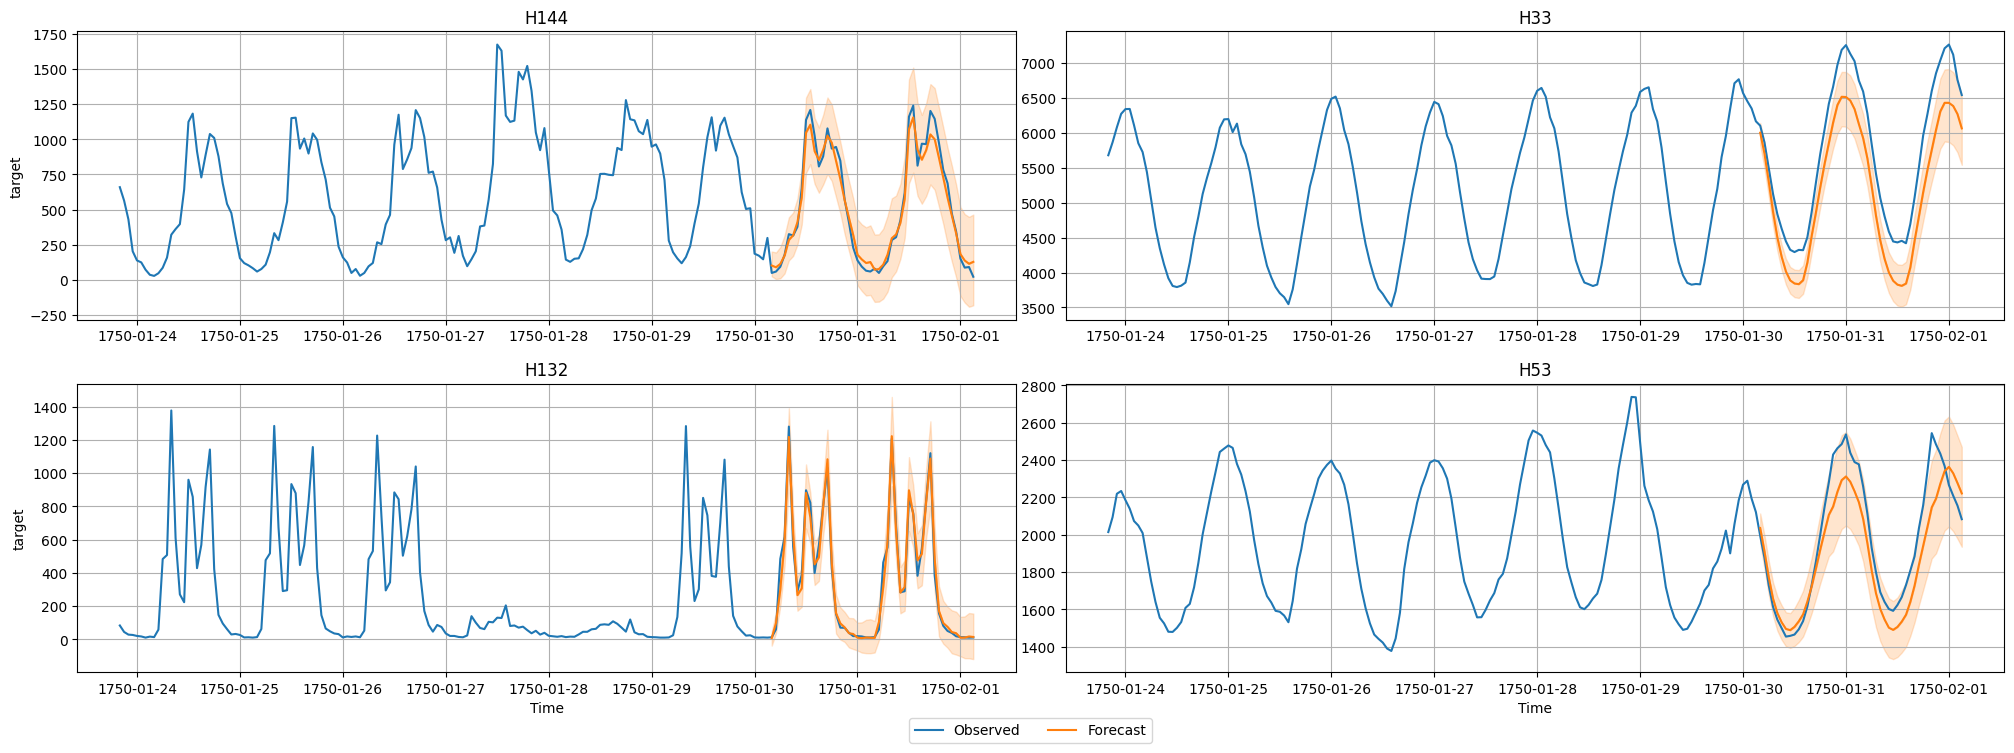

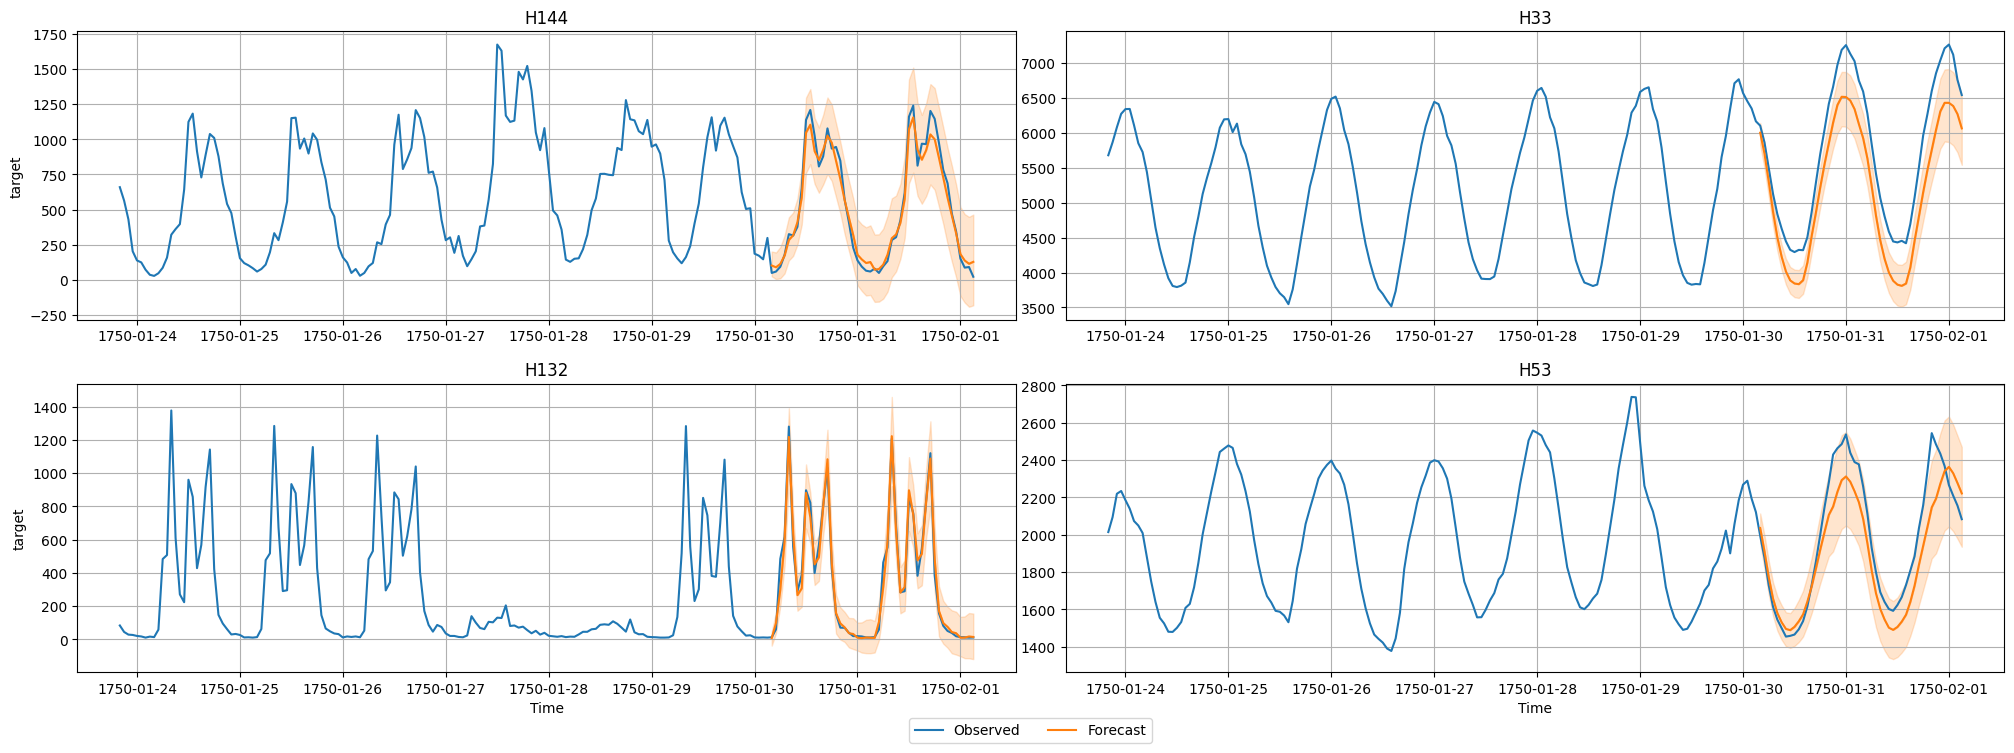

In [12]:
# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(
    test_data,
    predictions,
    quantile_levels=[0.1, 0.9],
    max_history_length=200,
    max_num_item_ids=4
)

## Evaluating Individual Model's Performance

In AutoGluon leaderboards, higher scores always correspond to better predictive performance. Therefore our MASE scores are multiplied by -1, such that higher "negative MASE"s correspond to more accurate forecasts

In [13]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.697013,-0.787378,51.918584,41.123005,0.892201,9
1,Chronos[bolt_small],-0.725739,-0.812070,3.711122,4.761748,18.850839,7
2,RecursiveTabular,-0.862797,-0.933874,0.846291,0.697664,15.338143,3
3,SeasonalNaive,-1.022854,-1.216909,0.196031,0.163952,0.047073,2
4,DirectTabular,-1.648202,-1.372871,0.609011,0.472579,5.876186,4
5,ETS,-1.806128,-1.965912,46.277390,34.802040,0.090688,5
6,Theta,-1.905367,-2.142551,2.477229,2.469879,0.064828,6
7,TemporalFusionTransformer,-2.102643,-2.341019,0.456667,0.388974,232.607253,8
8,Naive,-6.696079,-6.662942,0.185001,4.961465,0.067927,1
